In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

from utils import *

In [12]:
data = pd.read_csv("order_data.csv")
data.head()

,Date,TimeOfDay,MenuItem,Quantity
0,2023-01-01,07:00,Chicken Tikka Masala,2
1,2023-01-01,07:00,Shrimp Scampi,2
2,2023-01-01,07:00,Chicken Alfredo,3
3,2023-01-01,07:00,Caesar Salad,1
4,2023-01-01,07:00,Tiramisu,3


In [13]:
def extract_hour(timestamp):
    time_obj = datetime.strptime(timestamp, '%H:%M')
    return time_obj.hour

# Applying the function to the 'TimeofDay' column to extract hours
data['TimeOfDay'] = data['TimeOfDay'].apply(extract_hour)

In [14]:
# Convert 'Date' column to datetime format and 'TimeOfDay' to timedelta format
data['DateTime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['TimeOfDay'], unit='h')

In [15]:
# Convert 'Date' column to numeric representation
data['Date'] = pd.to_datetime(data['Date'])
start_date = data['Date'].min()
data['NumericDate'] = (data['Date'] - start_date).dt.days + 1

In [16]:
data = data.groupby(['DateTime', 'Date', 'NumericDate', 'TimeOfDay', 'MenuItem']).agg({'Quantity': 'sum'}).reset_index()
data.head(5)

,DateTime,Date,NumericDate,TimeOfDay,MenuItem,Quantity
0,2023-01-01 07:00:00,2023-01-01,1,7,Beef Stroganoff,5
1,2023-01-01 07:00:00,2023-01-01,1,7,Beef Tacos,4
2,2023-01-01 07:00:00,2023-01-01,1,7,Breakfast Combo,1
3,2023-01-01 07:00:00,2023-01-01,1,7,Caesar Salad,1
4,2023-01-01 07:00:00,2023-01-01,1,7,Chicken Alfredo,3


In [17]:
categorical_columns = ['MenuItem']
data = encodeLabels(data, categorical_columns)
data.head()

,DateTime,Date,NumericDate,TimeOfDay,MenuItem,Quantity
0,2023-01-01 07:00:00,2023-01-01,1,7,1,5
1,2023-01-01 07:00:00,2023-01-01,1,7,2,4
2,2023-01-01 07:00:00,2023-01-01,1,7,3,1
3,2023-01-01 07:00:00,2023-01-01,1,7,4,1
4,2023-01-01 07:00:00,2023-01-01,1,7,5,3


In [18]:
# Selecting features and target
X_poly = data[['NumericDate', 'TimeOfDay', 'MenuItem']]
y_poly = data['Quantity']

# Splitting the data into training and testing sets
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size=0.4, random_state=42)

# Polynomial features transformation (you can adjust the degree as needed)
poly = PolynomialFeatures(degree=5)
X_train_poly_t = poly.fit_transform(X_train_poly)
X_test_poly_t = poly.transform(X_test_poly)

# Creating and fitting the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly_t, y_train_poly)

# Predicting on the test set
predictions_poly = model_poly.predict(X_test_poly_t)

evaluate(model_poly, predictions_poly, X_test_poly_t, y_test_poly)

Model Performance
Score: 0.33566808314779006
Mean Squared Error (MSE): 37.51703031893388
Root Mean Squared Error (RMSE): 6.12511471883865
Mean Absolute Error (MAE): 4.809340832806286
R-squared (R2): 0.33566808314779006


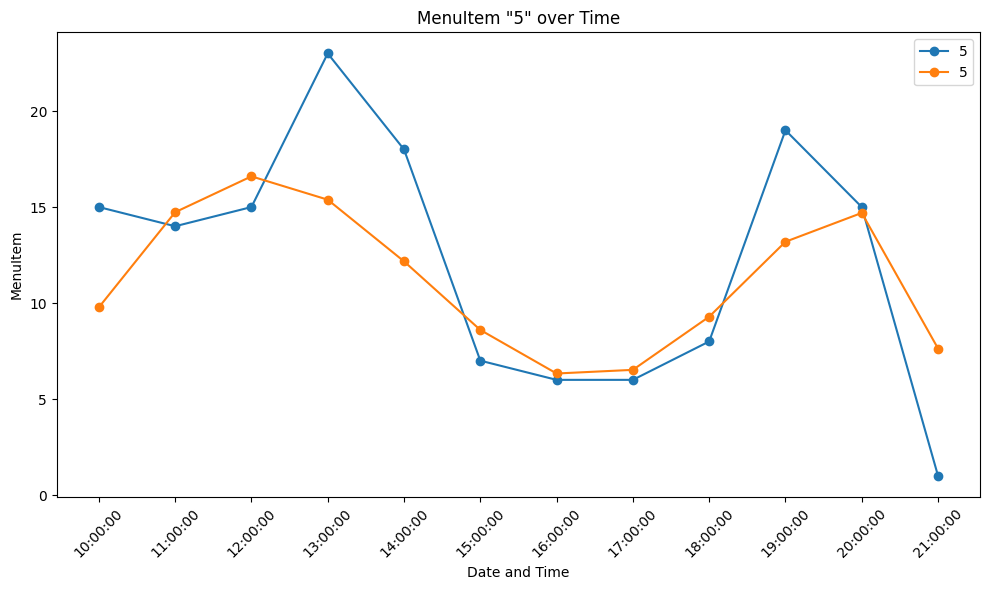

In [20]:
plot_predictions(model_poly, data, '2023-07-20', 5, poly)